In [ ]:
NEWSAPI_APP_KEY = ""
NEWSAPI_APP_ID = ""

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import news_signals
import datetime
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:


# Parameters for the financial data
ticker = "TSLA"            # Change ticker if needed
start_date = "2023-01-01"    # Start date for historical data
end_date = "2023-12-31"      # End date for historical data
window_size = 3            # 3-day rolling window

# Download daily stock data
data = yf.download(ticker, start=start_date, end=end_date)
data.index = pd.to_datetime(data.index)

def classify_window(window):
    """
        +1 if cumulative return > 5% and > volatility  (upward trend)
        -1 if cumulative return < -5% and < -volatility (downward trend)
         0 otherwise (neutral)
    """
    first_open = float(window['Open'].iloc[0])
    last_close = float(window['Close'].iloc[-1])
    cumulative_return = (last_close - first_open) / first_open
    daily_returns = (window['Close'] - window['Open']) / window['Open']
    volatility = float(daily_returns.std())
    
    if cumulative_return > 0.05 and cumulative_return > volatility:
        return 1
    elif cumulative_return < -0.05 and cumulative_return < -volatility:
        return -1
    else:
        return 0

# Apply a rolling window to classify the trend for each period
trend_results = []
dates = []
for i in range(window_size - 1, len(data)):
    window = data.iloc[i - window_size + 1 : i + 1]
    trend = classify_window(window)
    trend_results.append(trend)
    dates.append(data.index[i])

# Create a DataFrame with the trend classifications (using the last day of each window as the index)
rolling_trend_df = pd.DataFrame({'Trend': trend_results}, index=dates)
print(rolling_trend_df)


NameError: name 'yf' is not defined

Class Distribution (Percentage):
Trend
 0    67.741935
 1    21.774194
-1    10.483871
Name: proportion, dtype: float64


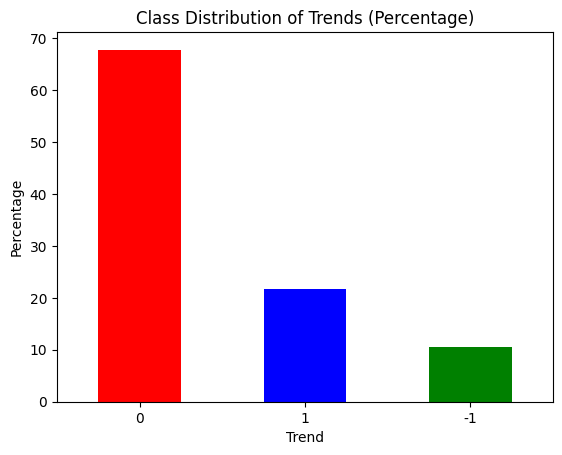

In [7]:

class_distribution = rolling_trend_df['Trend'].value_counts(normalize=True) * 100
print("Class Distribution (Percentage):")
print(class_distribution)

# Plot the class distribution as percentages
class_distribution.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Class Distribution of Trends (Percentage)')
plt.xlabel('Trend')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [ ]:

HEADERS = {
    'X-AYLIEN-NewsAPI-Application-ID': NEWSAPI_APP_ID,
    'X-AYLIEN-NewsAPI-Application-Key': NEWSAPI_APP_KEY
}

params = {
    "published_at.start": "2023-01-01T00:00:00.000Z",
    "published_at.end": "2023-12-31T00:00:00.000Z",
    "language": "(en)",
    "entities": '{{surface_forms:("TSLA" OR "Tesla" OR "Elon Musk") AND overall_prominence:>=0.7}}',
    "source.rankings.alexa.rank.min": "1",
    "source.rankings.alexa.rank.max": 7,
    "per_page": 100,
}

news_data = []
cursor = "*" 
while cursor:
    if cursor != "*":
        params["cursor"] = cursor

    response = requests.get("https://api.aylien.com/v6/news/stories", params=params, headers=HEADERS)
    result = response.json()

    stories = result.get("stories", [])
    if not stories:
        print("No more articles found. Stopping pagination.")
        break  
    for s in stories:
        news_data.append({
            "author": s.get("author", "Unknown"),
            "published_at": s.get("published_at", ""),
            "title": s.get("title", ""),
            "body": s.get("body", ""),
            "source": s.get("source", {}).get("name", ""),
            "url": s.get("links", {}).get("permalink", "")
        })

    print(f"Retrieved {len(stories)} articles. Total so far: {len(news_data)}")

    cursor = result.get("next_page_cursor")

news_df = pd.DataFrame(news_data)
news_csv_file = "entity_news_paged.csv"
news_df.to_csv(news_csv_file, index=False)
print(f"News data saved to {news_csv_file} with {len(news_df)} articles")


In [ ]:
news_df = pd.read_csv("entity_news_paged.csv")
news_df["published_at"] = pd.to_datetime(news_df["published_at"]).dt.tz_convert(None)

rolling_trend_df_reset = rolling_trend_df.reset_index()
rolling_trend_df_reset.rename(columns={'index': 'Date'}, inplace=True)
rolling_trend_df_reset["Date"] = pd.to_datetime(rolling_trend_df_reset["Date"])
# Ensure the financial data is sorted by Date
rolling_trend_df_reset = rolling_trend_df_reset.sort_values("Date")

# Define the starting boundary for the news window (use your finance start date)
finance_start_date = pd.to_datetime("2023-01-01")

attached_news = []

# Set the initial previous date for the window
prev_date = finance_start_date

# Iterate over each financial date and attach news articles published in the interval [prev_date, current_date)
for current_date in rolling_trend_df_reset["Date"]:
    # Filter news articles: published on or after prev_date and before current_date
    mask = (news_df["published_at"] >= prev_date) & (news_df["published_at"] < current_date)
    window_news = news_df[mask]
    
    # Combine news articles from this window:
    # Concatenate the title and body for each article, separated by a newline.
    combined_text = "\n\n".join((window_news["title"] + "\n" + window_news["body"]).tolist())
    attached_news.append(combined_text)
    
    prev_date = current_date

rolling_trend_df_reset["News"] = attached_news
csv_filename = "trend_news.csv"
rolling_trend_df_reset.to_csv(csv_filename, index=False)
print(rolling_trend_df_reset)


NameError: name 'rolling_trend_df' is not defined

In [24]:
df = pd.read_csv("trend_news.csv")

# Fill missing values in the 'News' column with an empty string
news_text = df["News"].fillna("").astype(str)


vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(2,3),
    max_features=500000,
    min_df=5,
    max_df=0.2
)


tfidf_matrix = vectorizer.fit_transform(news_text)

# Display the shape of the resulting TF-IDF matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)

feature_names = vectorizer.get_feature_names_out()
print("First 20 feature names:", feature_names[:50])


TF-IDF matrix shape: (248, 7242)
First 20 feature names: ['000 500' '000 according' '000 car' '000 cars' '000 characters'
 '000 chargers' '000 deliveries' '000 electric' '000 employees' '000 ev'
 '000 evs' '000 followers' '000 higher' '000 home' '000 model' '000 month'
 '000 mr' '000 mr musk' '000 new' '000 nio' '000 people' '000 price'
 '000 tesla' '000 times' '000 tweets' '000 units' '000 users'
 '000 vehicle' '000 vehicles' '000 workers' '000 year' '000 yuan' '10 000'
 '10 2023' '10 billion' '10 cent' '10 million' '10 minutes' '10 times'
 '10 trillion' '10 week' '10 year' '10 year treasury' '10 years' '100 000'
 '100 billion' '100 futures' '100 index' '100 million' '100 million users']


In [26]:
y = df["Trend"]

# Split data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

# Initialize and train a Logistic Regression classifier
clf = LogisticRegression(max_iter=5000, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Display the test set accuracy and classification report
print("Test set accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display top features for each trend class
feature_names = vectorizer.get_feature_names_out()
for class_label in np.unique(y_train):
    class_index = list(clf.classes_).index(class_label)
    coef = clf.coef_[class_index]
    top_indices = np.argsort(coef)[-10:][::-1]
    print(f"\nTop features for trend class {class_label}:")
    for i in top_indices:
        print(f"{feature_names[i]}: {coef[i]:.4f}")

Test set accuracy: 78.00%

Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         3
           0       0.78      1.00      0.88        39
           1       0.00      0.00      0.00         8

    accuracy                           0.78        50
   macro avg       0.26      0.33      0.29        50
weighted avg       0.61      0.78      0.68        50


Top features for trend class -1:
steering wheels: 0.6320
musk publicly: 0.3887
russell brand: 0.3813
twitter employee: 0.3809
new users: 0.3521
gross margin: 0.3400
30 million: 0.3120
doge meme: 0.3028
price war: 0.3026
taylor swift: 0.2978

Top features for trend class 0:
scottish mortgage: 0.3526
mark zuckerberg: 0.2839
sues elon: 0.2354
sues elon musk: 0.2354
electrify america: 0.2298
mr zuckerberg: 0.2151
tesla build: 0.2027
donald trump: 0.2026
driving range: 0.1986
data privacy: 0.1969

Top features for trend class 1:
posts day: 0.4305
tesla private: 0.356

/opt/miniconda3/envs/news-signals/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/news-signals/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/news-signals/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 2),
        max_features=3000,
        min_df=3,
        max_df=0.9)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [1000, 3000, 5000],
    'tfidf__min_df': [2, 3, 5],
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'clf__C': [0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(news_text, df["Trend"])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}%".format(grid_search.best_score_ * 100))
